# Bước 1: Chuẩn bị Dữ liệu và Phân tích Khám phá (EDA)

**Mục tiêu:** Tải dữ liệu giá đóng cửa của 5 cổ phiếu blue-chip Việt Nam (HPG, VHM, MWG, VCB, FPT), tính log returns, xử lý dữ liệu, và thực hiện phân tích khám phá.

In [ ]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
# Import các hàm xử lý dữ liệu từ src/data_prep.py
import sys
sys.path.append('../src')
from data_prep import (
    load_multiple_csv_to_df, compute_log_returns, check_negative_or_zero,
    check_outliers, report_missing_values, save_to_csv
 )

## Tải dữ liệu giá đóng cửa của 5 cổ phiếu (15 năm gần nhất)

Lưu ý: Mã cổ phiếu Việt Nam trên Yahoo Finance thường có hậu tố '.VN' (ví dụ: HPG.VN).

In [4]:
processed_folder = '../data/processed'

print("Loading and merging raw data...")
data = load_multiple_csv_to_df('../data/raw', dropna_type=any, min_non_na=None)
print(f"Data shape after merge: {data.shape}")
# Remove rows with closing price <= 0
data = check_negative_or_zero(data)
print(f"Data shape after removing <=0: {data.shape}")
# Check missing values
report_missing_values(data)
# Save cleaned price data
price_path = os.path.join(processed_folder, 'price_cleaned.csv')
save_to_csv(data, price_path)
print(f"Saved cleaned price data to {price_path}")
# Compute log returns
log_returns = compute_log_returns(data)
# Round to 6 decimals for readability
log_returns = log_returns.round(6)
logret_path = os.path.join(processed_folder, 'log_returns.csv')
save_to_csv(log_returns, logret_path)
print(f"Saved log returns to {logret_path}")
print("Data preparation pipeline completed.")

Loading and merging raw data...
Data shape after merge: (2777, 5)
Data shape after removing <=0: (2777, 5)
Missing values per ticker:
FPT_DATA    0
HPG_DATA    0
MWG_DATA    0
VCB_DATA    0
VIC_DATA    0
dtype: int64
Total number of rows with missing values: 0
Saved cleaned price data to ../data/processed\price_cleaned.csv
Saved log returns to ../data/processed\log_returns.csv
Data preparation pipeline completed.


c:\Users\HLC\OneDrive\Duong's Documents\Projects\garch-evt-copula-modeling\notebooks\../src\data_prep.py:21: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')


## Phân tích khám phá: Vẽ biểu đồ log returns và tính thống kê mô tả

In [12]:
log_returns.describe()

,FPT_DATA,HPG_DATA,MWG_DATA,VCB_DATA,VIC_DATA
count,2776.000000,2776.000000,2776.000000,2776.000000,2776.000000
mean,0.000927,0.000717,0.000990,0.000561,0.000464
std,0.016023,0.020616,0.021674,0.019499,0.020153
min,-0.072476,-0.072570,-0.072596,-0.402132,-0.320206
25%,-0.006858,-0.009663,-0.008906,-0.007989,-0.007181
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.008654,0.011270,0.010622,0.008661,0.007058
max,0.067629,0.067134,0.067624,0.067201,0.067659


In [13]:
# Tính các thống kê mô tả
desc_stats = log_returns.agg(['std', 'skew', 'kurtosis']).T
desc_stats

,std,skew,kurtosis
FPT_DATA,0.016023,-0.113517,3.611347
HPG_DATA,0.020616,-0.043926,1.762442
MWG_DATA,0.021674,-0.072160,2.161307
VCB_DATA,0.019499,-3.368644,68.326730
VIC_DATA,0.020153,-1.528141,27.629805


--- FPT_DATA ---


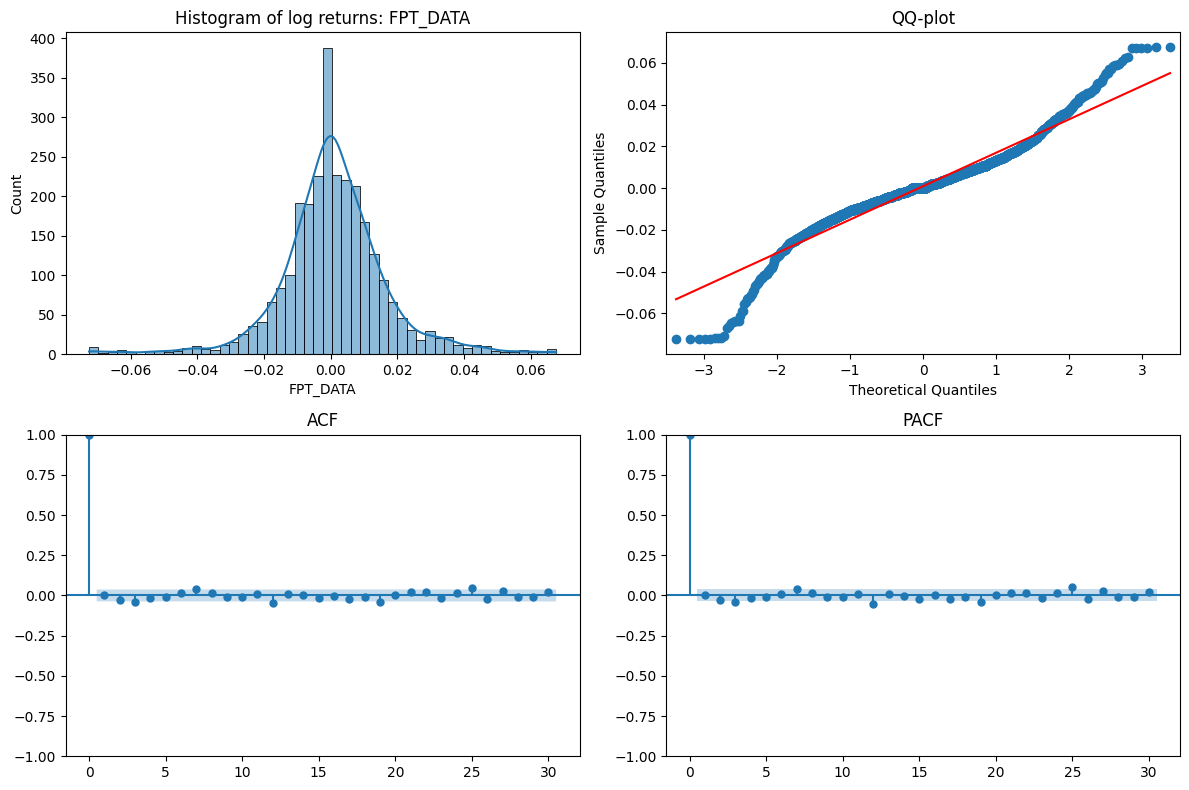


--- HPG_DATA ---


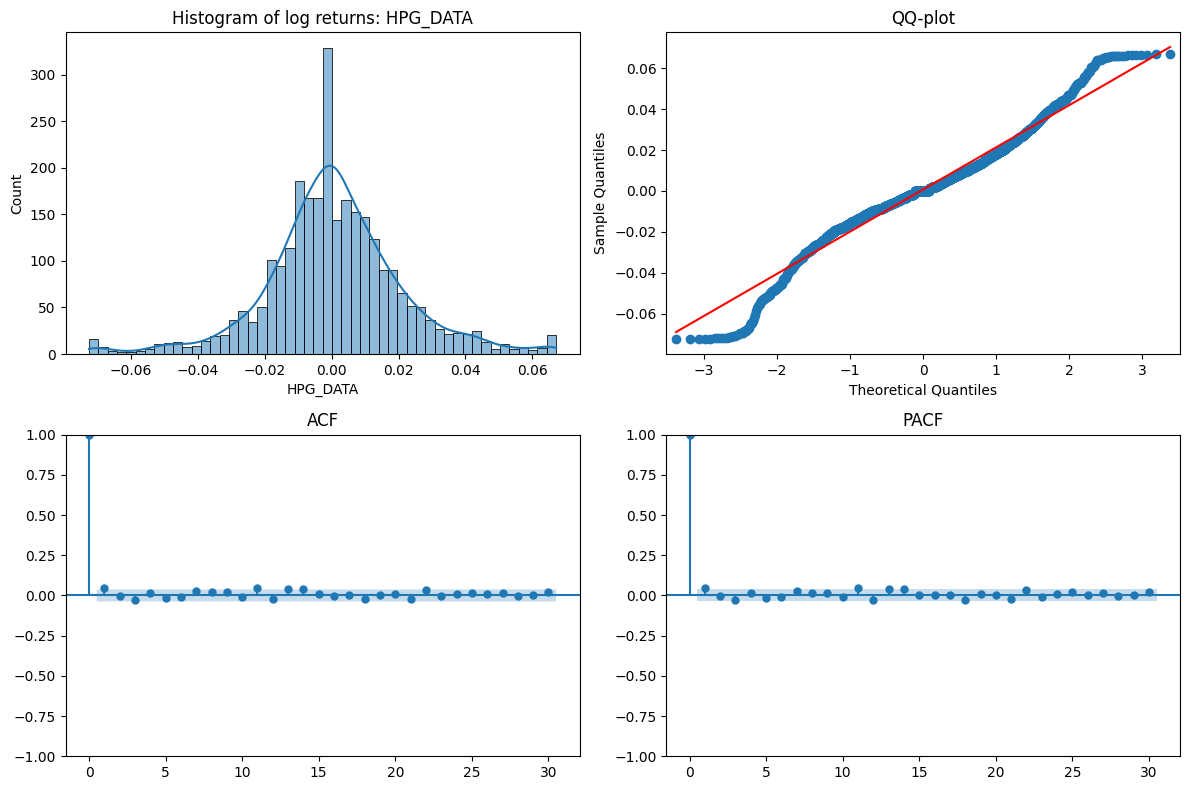


--- MWG_DATA ---


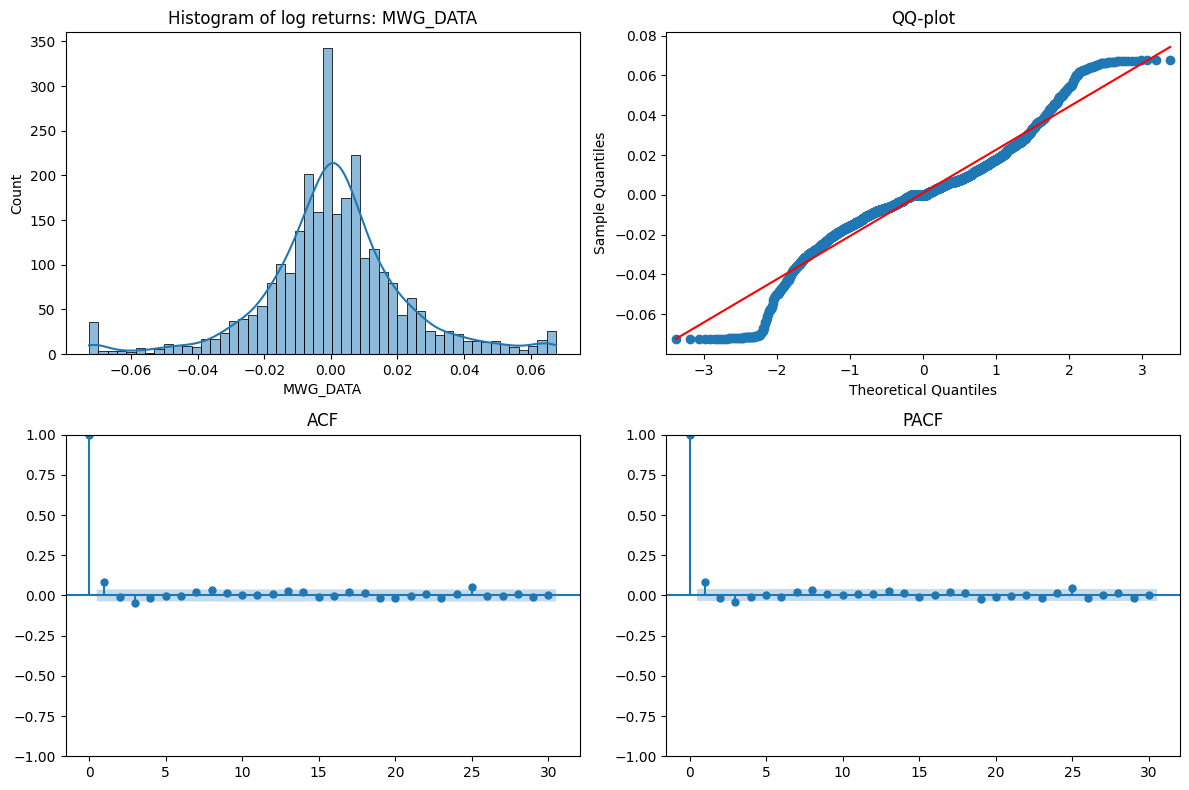


--- VCB_DATA ---


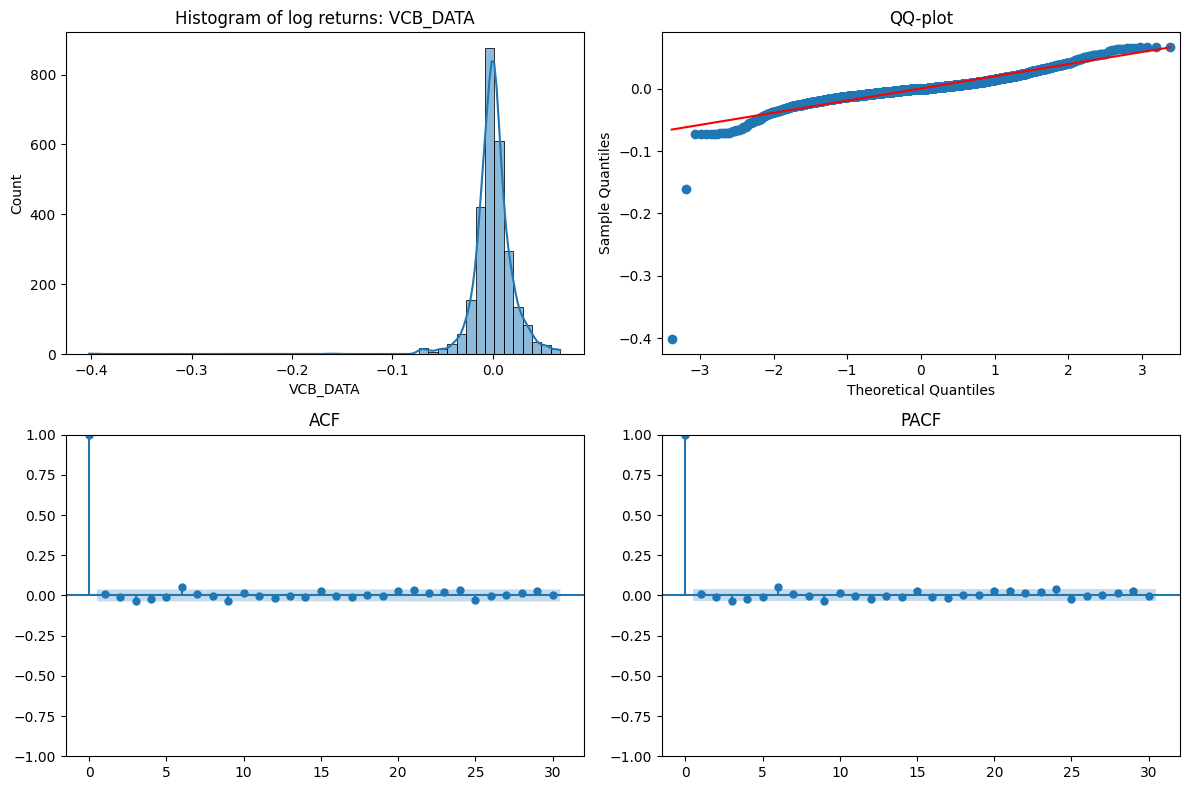


--- VIC_DATA ---


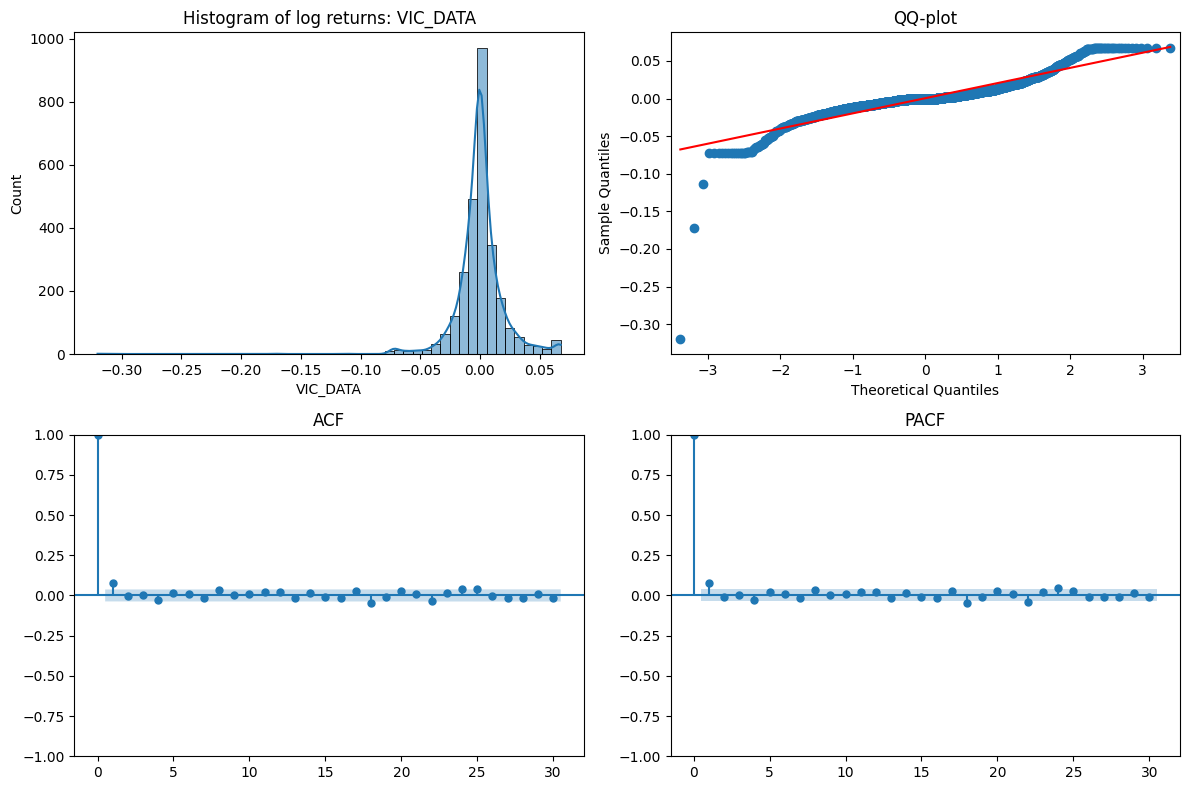

In [ ]:
# Phân tích khám phá log returns cho từng cổ phiếu
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
tickers = log_returns.columns.tolist()

for ticker in tickers:
    print(f'--- {ticker} ---')
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    # Histogram
    sns.histplot(log_returns[ticker].dropna(), bins=50, kde=True, ax=axes[0,0])
    axes[0,0].set_title(f'Histogram of log returns: {ticker}')
    # QQ-plot
    sm.qqplot(log_returns[ticker].dropna(), line='s', ax=axes[0,1])
    axes[0,1].set_title('QQ-plot')
    # ACF
    plot_acf(log_returns[ticker].dropna(), ax=axes[1,0], lags=30)
    axes[1,0].set_title('ACF')
    # PACF
    plot_pacf(log_returns[ticker].dropna(), ax=axes[1,1], lags=30, method='ywm')
    axes[1,1].set_title('PACF')
    plt.tight_layout()
    plt.show()

    print()

In [33]:
from scipy.stats import normaltest, jarque_bera
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox
from statsmodels.tsa.stattools import adfuller

results = []
for ticker in log_returns.columns:
    x = log_returns[ticker].dropna()
    dag_stat, dag_p = normaltest(x)
    jb_stat, jb_p = jarque_bera(x)
    arch_stat, arch_p, _, _ = het_arch(x)
    adf_stat, adf_p, _, _, _, _ = adfuller(x)
    # Sử dụng return_df=True để lấy đúng p-value
    lb_result = acorr_ljungbox(x, lags=[10], return_df=True)
    lb_p_value = lb_result['lb_pvalue'].iloc[0]
    results.append({
        'Ticker': ticker,
        'D’Agostino p-value': round(dag_p, 3),
        'Jarque-Bera p-value': round(jb_p, 3),
        'ARCH p-value': round(arch_p, 3),
        'ADF p-value': round(adf_p, 3),
        'Ljung-Box p-value (lag10)': round(lb_p_value, 3)
    })

test_results = pd.DataFrame(results).set_index('Ticker')
test_results

,D’Agostino p-value,Jarque-Bera p-value,ARCH p-value,ADF p-value,Ljung-Box p-value (lag10)
Ticker,,,,,
FPT_DATA,0.0,0.0,0.000,0.0,0.185
HPG_DATA,0.0,0.0,0.000,0.0,0.212
MWG_DATA,0.0,0.0,0.000,0.0,0.000
VCB_DATA,0.0,0.0,1.000,0.0,0.067
VIC_DATA,0.0,0.0,0.055,0.0,0.012


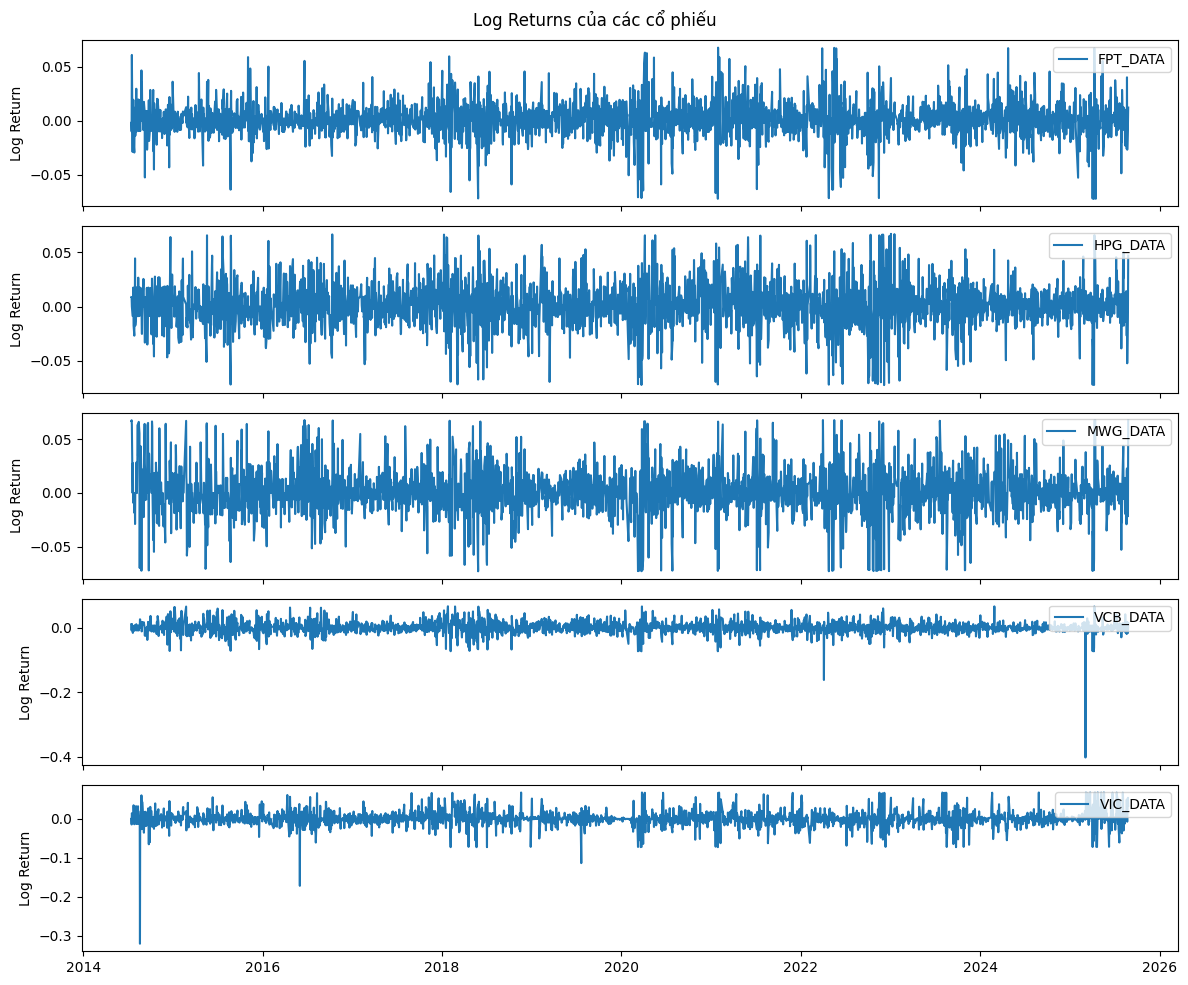

In [6]:
fig, axes = plt.subplots(len(tickers), 1, figsize=(12, 2*len(tickers)), sharex=True)
for i, ticker in enumerate(tickers):
    axes[i].plot(log_returns.index, log_returns[ticker], label=ticker)
    axes[i].set_ylabel('Log Return')
    axes[i].legend(loc='upper right')
plt.suptitle('Log Returns của các cổ phiếu')
plt.tight_layout()
plt.show()

In [21]:
# Thống kê mở rộng cho log returns
def calc_stats(df):
    stats = pd.DataFrame(index=df.columns)
    stats['VaR_5%'] = df.quantile(0.05)
    stats['sharpe'] = df.mean() / df.std()
    stats['autocorr_lag1'] = df.apply(lambda x: x.autocorr(lag=1))
    stats['num_pos'] = (df > 0).sum()
    stats['num_neg'] = (df < 0).sum()
    return stats.round(6)

desc_stats_ext = calc_stats(log_returns)
desc_stats_ext

,VaR_5%,sharpe,autocorr_lag1,num_pos,num_neg
FPT_DATA,-0.022654,0.057837,0.004220,1344,1218
HPG_DATA,-0.032055,0.034762,0.045657,1303,1267
MWG_DATA,-0.032411,0.045660,0.086653,1334,1201
VCB_DATA,-0.025828,0.028778,0.006646,1289,1245
VIC_DATA,-0.027380,0.023000,0.074642,1209,1196


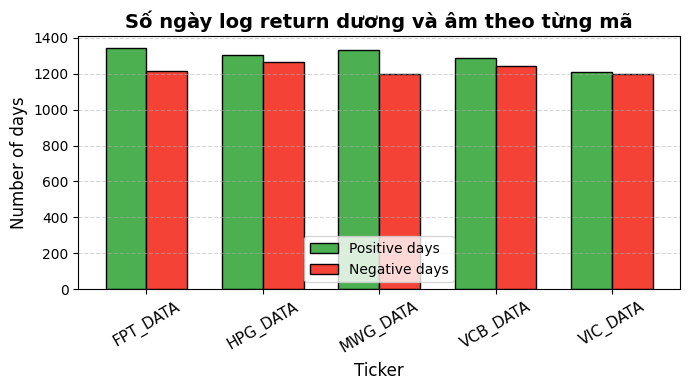

In [19]:
import matplotlib.pyplot as plt

# Tính số ngày positive và negative cho từng mã
num_pos = (log_returns > 0).sum()
num_neg = (log_returns < 0).sum()

# Vẽ biểu đồ bar với màu sắc đẹp hơn
fig, ax = plt.subplots(figsize=(7, 4))
bar_width = 0.35
index = np.arange(len(log_returns.columns))

ax.bar(index, num_pos, bar_width, label='Positive days', color='#4CAF50', edgecolor='black')
ax.bar(index + bar_width, num_neg, bar_width, label='Negative days', color='#F44336', edgecolor='black')

ax.set_xlabel('Ticker', fontsize=12)
ax.set_ylabel('Number of days', fontsize=12)
ax.set_title('Số ngày log return dương và âm theo từng mã', fontsize=14, fontweight='bold')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(log_returns.columns, rotation=30, fontsize=11)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

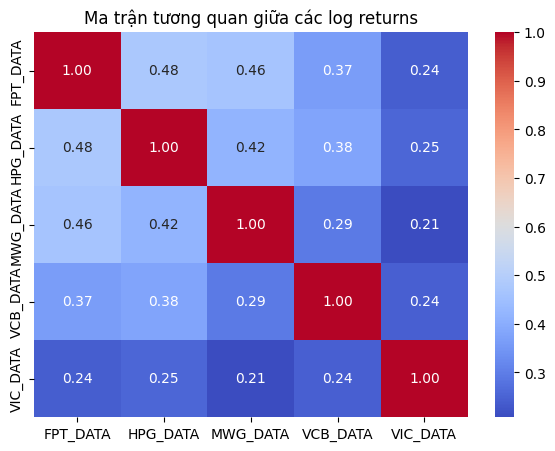

In [37]:
# 1. Ma trận tương quan
corr_matrix = log_returns.corr()
plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Ma trận tương quan giữa các log returns")
plt.show()

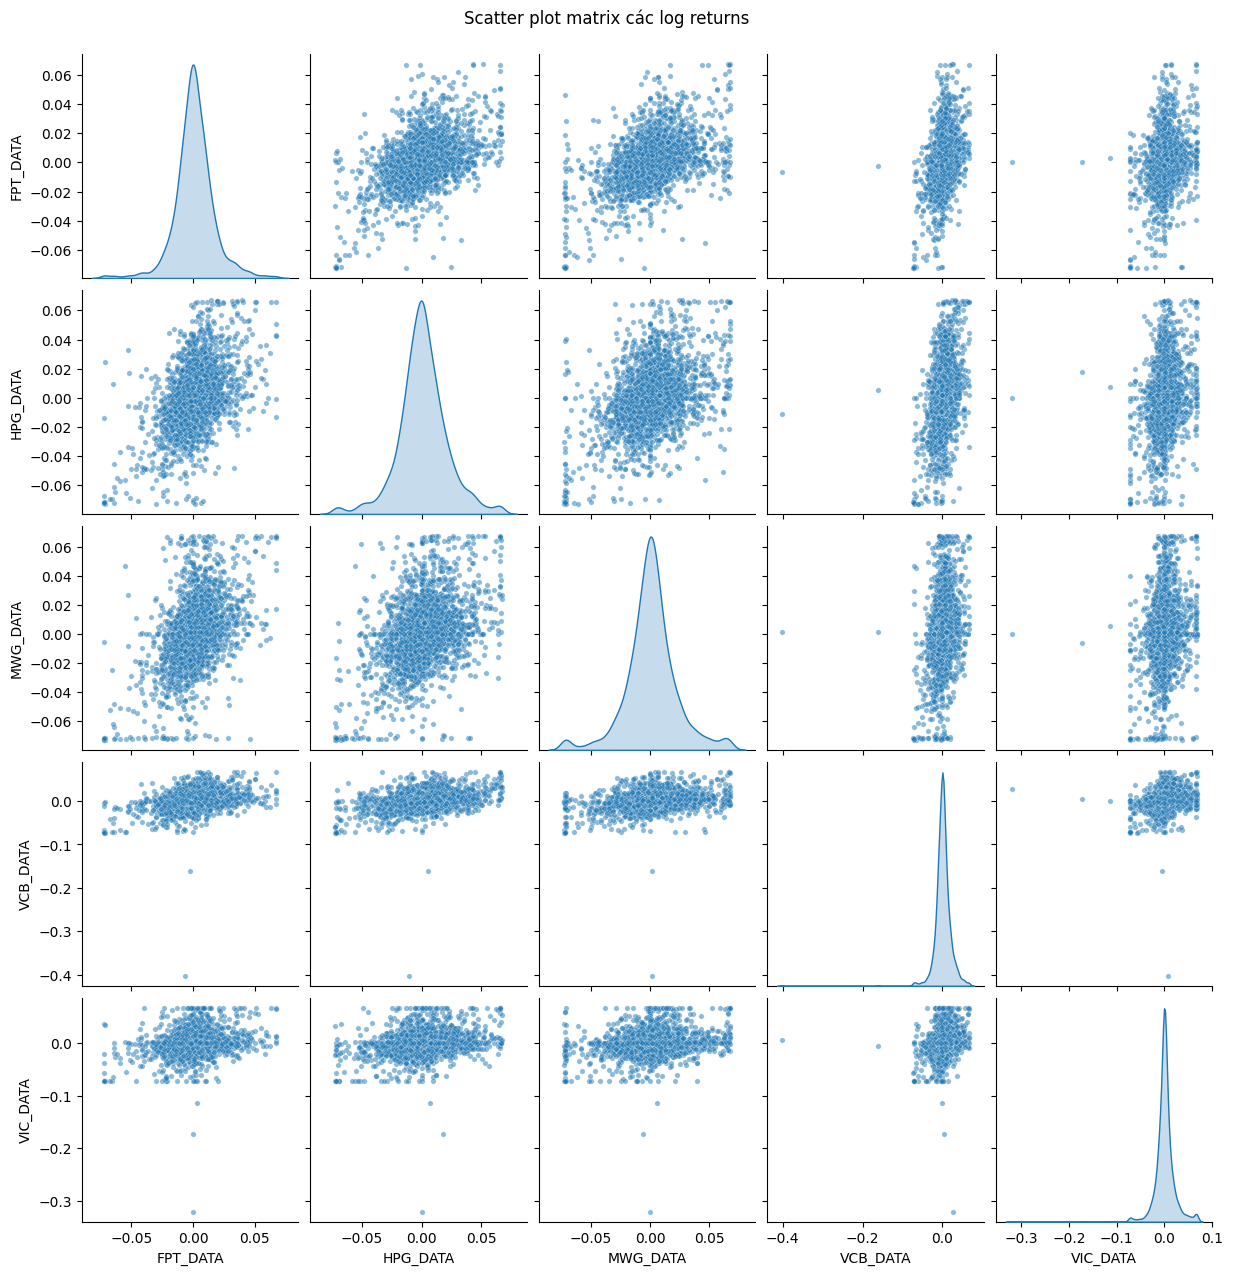

In [36]:
# 2. Biểu đồ phân tán (scatter plot matrix)
sns.pairplot(log_returns, diag_kind='kde', plot_kws={'alpha':0.5, 's':15})
plt.suptitle("Scatter plot matrix các log returns", y=1.02)
plt.show()

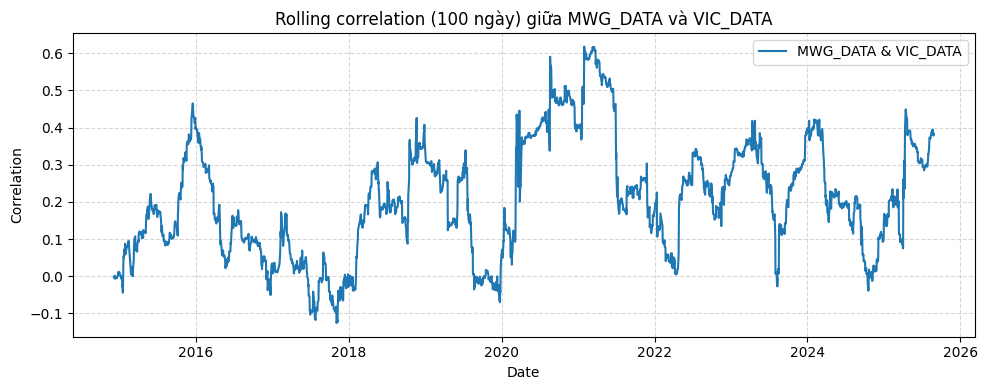

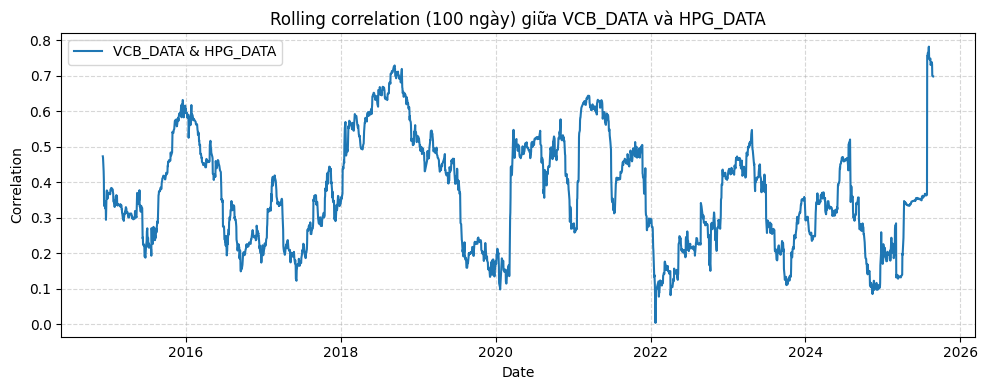

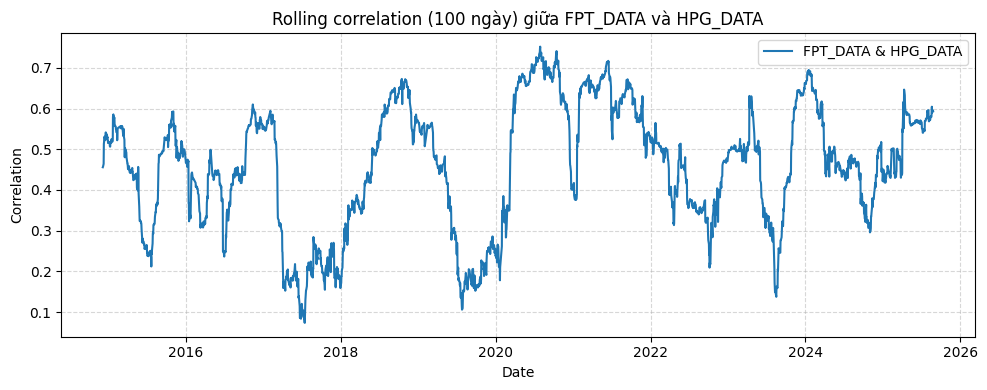

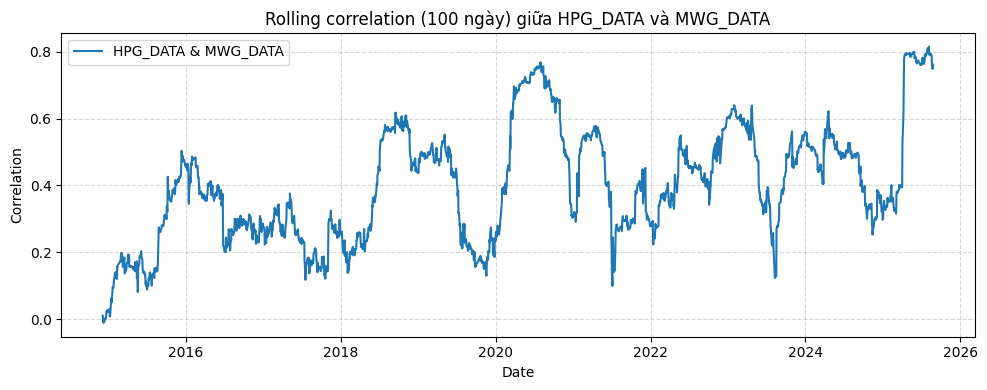

In [44]:
window = 100
pairs = [('MWG_DATA', 'VIC_DATA'), ('VCB_DATA', 'HPG_DATA'), ('FPT_DATA', 'HPG_DATA'), ('HPG_DATA', 'MWG_DATA')]

for pair in pairs:
    rolling_corr = log_returns[pair[0]].rolling(window).corr(log_returns[pair[1]])
    plt.figure(figsize=(10, 4))
    plt.plot(rolling_corr, label=f'{pair[0]} & {pair[1]}')
    plt.title(f'Rolling correlation ({window} ngày) giữa {pair[0]} và {pair[1]}')
    plt.xlabel('Date')
    plt.ylabel('Correlation')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()